In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [16]:
model_name = "bert-base-uncased"
tokenizer_base = AutoTokenizer.from_pretrained(model_name)
model_base = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=4
)
model_base.eval()

label_names = ["World", "Sports", "Business", "Sci/Tech"]
print("Model loaded")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded


In [17]:
model_path = "../models/bert-ag-news"
tokenizer_ft = AutoTokenizer.from_pretrained(model_path)
model_ft = AutoModelForSequenceClassification.from_pretrained(model_path)
model_ft.eval()

label_names = ["World", "Sports", "Business", "Sci/Tech"]
print("Fine-tuned model loaded")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Fine-tuned model loaded


In [18]:
def predict(text, model, tokenizer):
    """predict class for a single text"""

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=-1)
    pred_id: int = probs.argmax().item()  # type: ignore
    confidence = probs[0, pred_id].item()

    return pred_id, label_names[pred_id], confidence


In [19]:
test_texts = [
    "The stock market crashed after the Federal Reserve raised interest rates",
    "Manchester United won the championship after a thrilling final match",
    "NASA launched a new satellite to study climate change",
    "The president met with foreign leaders to discuss trade agreements",
]

print("=" * 60)
for text in test_texts:
    _, label_base, conf_base = predict(text, model_base, tokenizer_base)
    _, label_ft, conf_ft = predict(text, model_ft, tokenizer_ft)

    print(f"Text: {text[:50]}...")
    print(f"  Baseline:   {label_base} ({conf_base:.2%})")
    print(f"  Fine-tuned: {label_ft} ({conf_ft:.2%})")
    print()

Text: The stock market crashed after the Federal Reserve...
  Baseline:   Business (30.70%)
  Fine-tuned: Business (94.82%)

Text: Manchester United won the championship after a thr...
  Baseline:   Business (34.08%)
  Fine-tuned: Sports (72.34%)

Text: NASA launched a new satellite to study climate cha...
  Baseline:   Sci/Tech (31.08%)
  Fine-tuned: Sci/Tech (97.72%)

Text: The president met with foreign leaders to discuss ...
  Baseline:   Sci/Tech (31.45%)
  Fine-tuned: World (63.28%)



In [20]:
from datasets import load_dataset

dataset = load_dataset("ag_news")
test_texts = dataset["test"]["text"][:200]
test_labels = dataset["test"]["label"][:200]

predictions = []
for text in test_texts:
    pred_id, _, _ = predict(text, model_ft, tokenizer_ft)
    predictions.append(pred_id)

print("Predictions done")

Predictions done


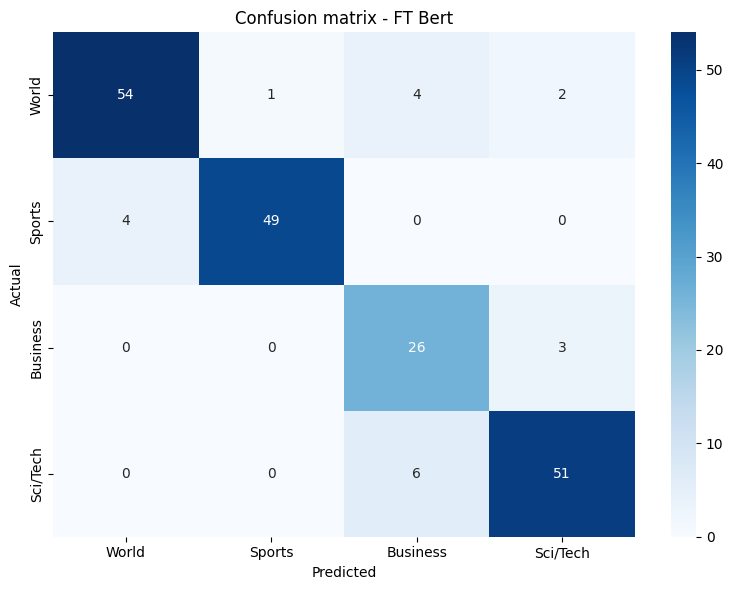

              precision    recall  f1-score   support

       World       0.93      0.89      0.91        61
      Sports       0.98      0.92      0.95        53
    Business       0.72      0.90      0.80        29
    Sci/Tech       0.91      0.89      0.90        57

    accuracy                           0.90       200
   macro avg       0.89      0.90      0.89       200
weighted avg       0.91      0.90      0.90       200



In [21]:
cm = confusion_matrix(test_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion matrix - FT Bert")
plt.tight_layout()
plt.show()

print(classification_report(test_labels, predictions, target_names=label_names))